In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# 데이터 불러오기
df = pd.read_csv('data/Churn_Modelling.csv')

# 불필요한 컬럼 제거
df = df.drop(['RowNumber', 'CustomerId', 'Surname','CreditScore','Tenure','HasCrCard','EstimatedSalary'], axis=1)

# 연속형 변수들을 로그 스케일링 실시 ('Age','Balance')
df['LogAge'] = df['Age'].apply(lambda x: np.log1p(x))
df['LogBalance'] = df['Balance'].apply(lambda x: np.log1p(x))

# 타겟과 피처 분리
X = df.drop(['Exited', 'Balance', 'Age'], axis=1)
y = df['Exited']

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [3]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

# CatBoost는 범주형 변수 인덱스만 지정하면 인코딩 필요 없음
cat_features = [X.columns.get_loc('Geography'), X.columns.get_loc('Gender')]

# 1차: RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

cat_model = CatBoostClassifier(verbose=0, random_seed=42)
param_dist_cat = {
    'iterations': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(1, 10)
}
random_search_cat = RandomizedSearchCV(
    cat_model, param_distributions=param_dist_cat, n_iter=20, cv=3, scoring='f1', random_state=42, n_jobs=-1
)
random_search_cat.fit(X_train, y_train, cat_features=cat_features)
print("CatBoost 1차 Best Params:", random_search_cat.best_params_)

# 2차: GridSearchCV (1차 결과 기반)
best_params_cat = random_search_cat.best_params_
param_grid_cat = {
    'iterations': [best_params_cat['iterations']-100, best_params_cat['iterations'], best_params_cat['iterations']+100],
    'learning_rate': [best_params_cat['learning_rate']*0.8, best_params_cat['learning_rate'], best_params_cat['learning_rate']*1.2],
    'depth': [best_params_cat['depth']-1, best_params_cat['depth'], best_params_cat['depth']+1],
    'l2_leaf_reg': [best_params_cat['l2_leaf_reg']*0.8, best_params_cat['l2_leaf_reg'], best_params_cat['l2_leaf_reg']*1.2]
}
grid_search_cat = GridSearchCV(
    cat_model, param_grid=param_grid_cat, cv=3, scoring='f1', n_jobs=-1
)
grid_search_cat.fit(X_train, y_train, cat_features=cat_features)
print("CatBoost 최종 Best Params:", grid_search_cat.best_params_)


CatBoost 1차 Best Params: {'depth': 4, 'iterations': 661, 'l2_leaf_reg': np.float64(7.62522284353982), 'learning_rate': np.float64(0.07234221521788219)}
CatBoost 최종 Best Params: {'depth': 4, 'iterations': 561, 'l2_leaf_reg': np.float64(6.1001782748318565), 'learning_rate': np.float64(0.08681065826145862)}


In [4]:
import pickle

# 모델 저장
filename = '../models/Catboost.pkl'
pickle.dump(random_search_cat, open(filename, 'wb'))

# 모델 불러오기
loaded_svc = pickle.load(open(filename, 'rb'))

In [5]:
from sklearn.metrics import classification_report, roc_auc_score

# CatBoost 최적 모델
cat_best = grid_search_cat.best_estimator_
y_pred_cat = cat_best.predict(X_test)
y_proba_cat = cat_best.predict_proba(X_test)[:,1]
print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_cat))
print("CatBoost ROC AUC:", roc_auc_score(y_test, y_proba_cat))


CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.50      0.60       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

CatBoost ROC AUC: 0.8736841618197551


In [6]:
from sklearn.metrics import confusion_matrix

print("CatBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))

CatBoost Confusion Matrix:
 [[1534   59]
 [ 205  202]]


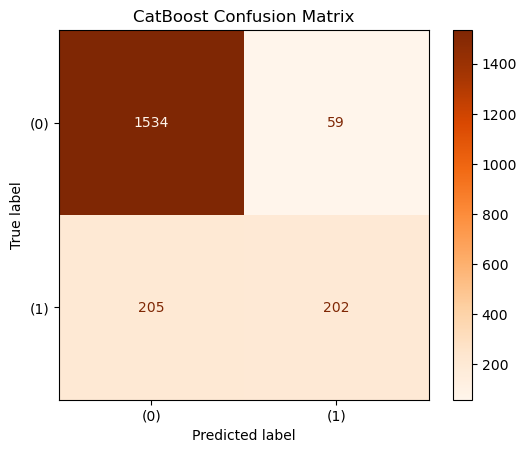

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# CatBoost
cm_cat = confusion_matrix(y_test, y_pred_cat)
disp_cat = ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=["(0)", "(1)"])
disp_cat.plot(cmap='Oranges')
plt.title("CatBoost Confusion Matrix")
plt.show()

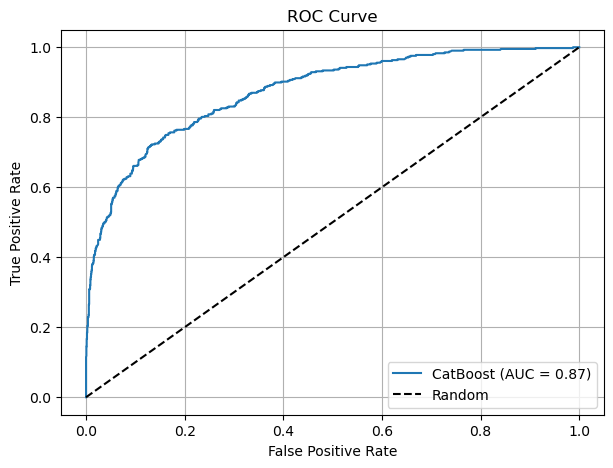

In [8]:
from sklearn.metrics import roc_curve, auc

# CatBoost
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

plt.figure(figsize=(7,5))
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {roc_auc_cat:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

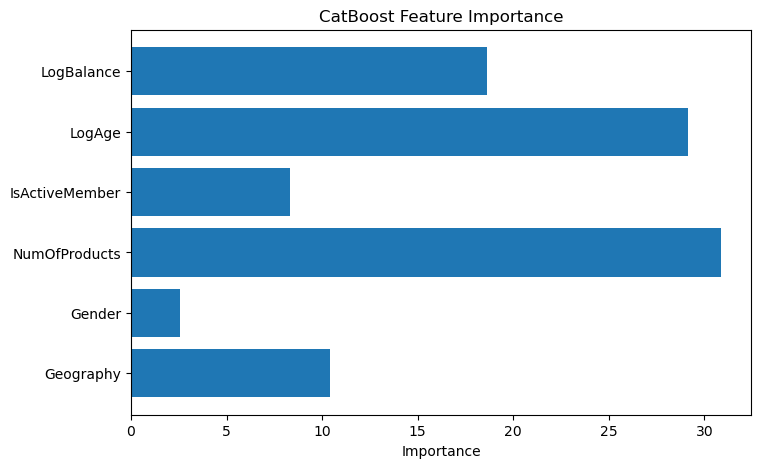

In [9]:
importances = cat_best.get_feature_importance()
features = X_test.columns
plt.figure(figsize=(8,5))
plt.barh(features, importances)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

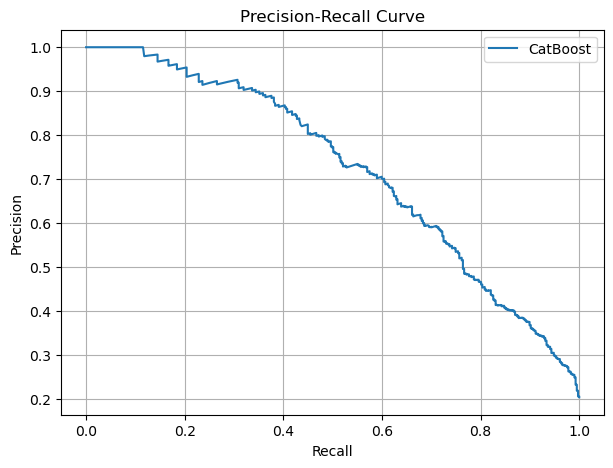

In [10]:
from sklearn.metrics import precision_recall_curve


precision_cat, recall_cat, _ = precision_recall_curve(y_test, y_proba_cat)

plt.figure(figsize=(7,5))
plt.plot(recall_cat, precision_cat, label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()